In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

Here is some utility functions that would help us during the EDA:

In [25]:
def get_img_dimensions(img_path):
    with Image.open(img_path) as img:
        return img.size

def rle_to_mask(starts, lengths, height, width):
    # Create an empty array of zeros of shape (height, width)
    mask = np.zeros(height * width, dtype=np.uint8)

    # For each start and length, set the corresponding values in the mask to 1
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1

    # Reshape the mask into the desired dimensions
    mask = mask.reshape((height, width))
    mask = mask.T
    return mask

def create_mask(mask_array, width, height):
    mask = np.zeros((width, height), dtype=np.int16)
    # if element == element:
    if isinstance(mask_array, str):
        split = mask_array.split()
        startP, lengthP = [np.array(x, dtype=int) for x in (split[::2], split[1::2])]
        mask += rle_to_mask(startP, lengthP, width, height)
    return mask

def calc_mask_size(pixelStr: str):
    if (pixelStr == pixelStr):
        split = pixelStr.split(" ")
        lengthP = np.array(split[1::2], dtype=int)
        return lengthP.sum()
    else:
        return 0


In [26]:
# aka env variables
BASE_DIR = '/kaggle/input/airbus-ship-detection'
TEST_IMG_DIR = os.path.join(BASE_DIR,'test_v2')
TRAIN_IMG_DIR = os.path.join(BASE_DIR,'train_v2')
TRAIN_DATASET_CSV = os.path.join(BASE_DIR,'train_ship_segmentations_v2.csv')
TRAIN_DATASET_WITH_IMAGE_DIMENTIONS = '/kaggle/input/dataset-with-img-dimentions/dataset_with_image_dims'

In [27]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)
display(df.head(10))


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

Our dataset consists from 2 colums: ImageId and EncodedPixels. As we see, the ImageId column contains a repeating image names. Since the dataset description says that some images have multiple ships, my assumption is that EncodedPixels column contains a mask for a single ship per image, so if the image has N numer of ships - it would have N number of records in our dataset. To check this - lets display the images and corresponding masks for first 10 images (to do this we would use utility function defined at the begining of this notebook).

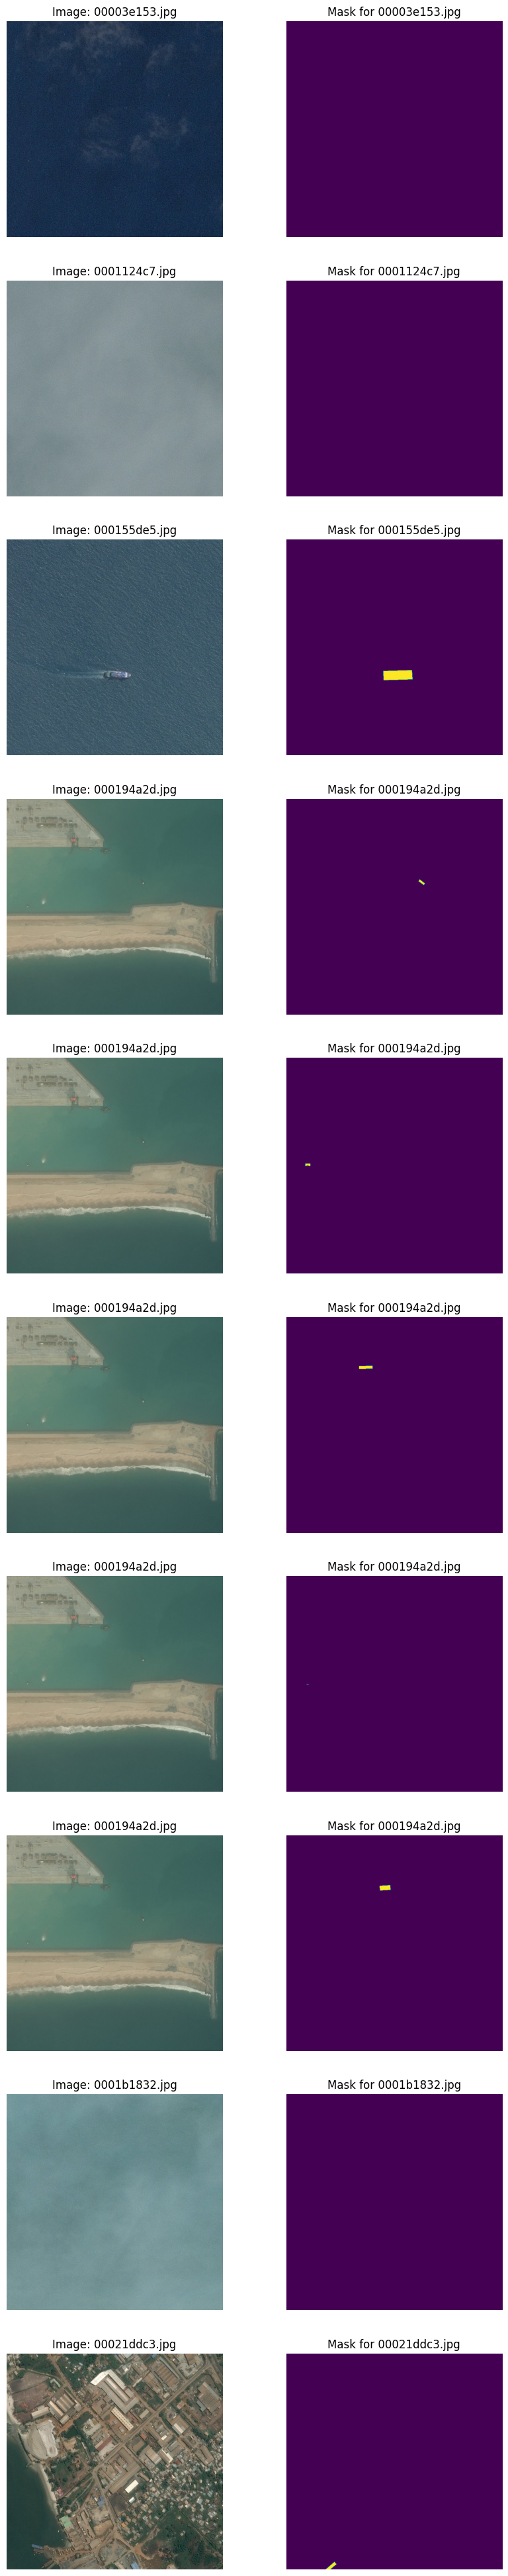

In [28]:
fig, ax = plt.subplots(10,2 , figsize=(10, 50))

# Select first 10 images
img_names = df['ImageId'].head(10)
img_masks = df['EncodedPixels'].head(10)

for i in range(len(img_names)):
    img = Image.open(os.path.join(TRAIN_IMG_DIR, img_names.loc[i]))
    ax[i,0].imshow(img)
    width, height = img.size
    ax[i,1].imshow(create_mask(img_masks.loc[i],width,height))
    ax[i, 0].set_title(f'Image: {img_names.loc[i]}')
    ax[i, 1].set_title(f'Mask for {img_names.loc[i]}')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')


The assumption was correct: the duplicates of ImageIds indicate that the image has multiple ships present at it.
Lets create a countplot to check the distribution between empty vs non-empty images.
But before we do this, we would add column "has_ship" to make dataset manipulations easier.

Number of images with ships - 150000
Number of images withput ships - 42556
Empty to non-empty ratio - 3.5247673653538865


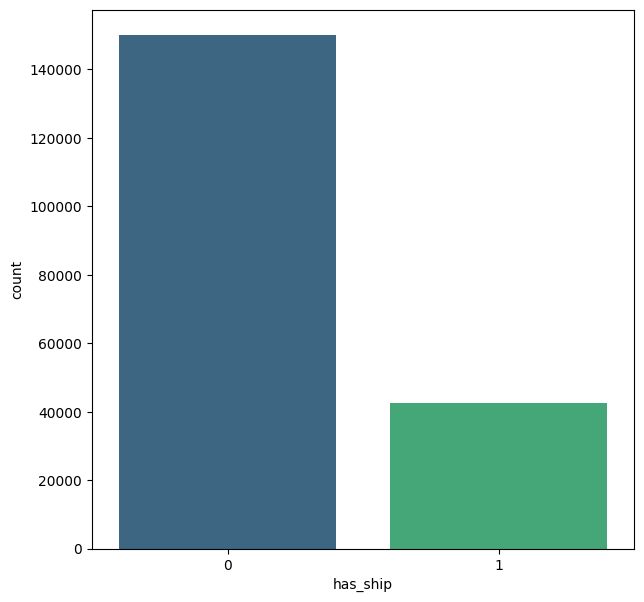

In [29]:
# Add info about ship beeing present in the image
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)

# Plot the chart, and drop repeating ImageIds since we are interested in number of images, not in total number of ships in the dataset
plt.figure(figsize=(7, 7))
sns.countplot(x='has_ship', data=df.drop_duplicates(subset='ImageId', keep='first'), palette='viridis')

# Calculate number of empty and non empty images
num_empty = len(df[df['has_ship'] == 0])
num_non_empty = len(df.drop_duplicates(subset='ImageId', keep='first')[df['has_ship'] != 0])

print(f"Number of images with ships - {num_empty}")
print(f"Number of images withput ships - {num_non_empty}")
print(f"Empty to non-empty ratio - {num_empty/num_non_empty}")

We see, that our dataset is highly imbalanced, the number of empty images is 3.5 times higher than non-empty. When preparing training set this should be kept in mind.
Next, lets calculate the area of each mask represented by the EncodedPixels, find the dimensions of each image and create a column "mask_size_percentage", so we would be able to anlalyse what percantage of the image the mask takes.

In [30]:
df['mask_size'] = df['EncodedPixels'].apply(lambda x: calc_mask_size(x))

The code in the next cell requires a lot of time to finish (35mins) because it requires a lot or read operations from storage. To speed up the execution of this notebook the resulting dataset of this operation was uploaded back to kaggle at this location - /kaggle/input/dataset-with-img-dimentions/dataset_with_image_dims.

In [31]:
# df['width'], df['height'] = zip(*df['ImageId'].apply(lambda x: get_img_dimensions(os.path.join(TRAIN_IMG_DIR, x))))
# df.to_csv('dataset_with_image_dims', index=False)

In [32]:
df = pd.read_csv(TRAIN_DATASET_WITH_IMAGE_DIMENTIONS)
display(df.describe())

has_ship      mask_size     width    height
count  231723.000000  231723.000000  231723.0  231723.0
mean        0.352675     552.784415     768.0     768.0
std         0.477804    1846.497860       0.0       0.0
min         0.000000       0.000000     768.0     768.0
25%         0.000000       0.000000     768.0     768.0
50%         0.000000       0.000000     768.0     768.0
75%         1.000000     132.500000     768.0     768.0
max         1.000000   25904.000000     768.0     768.0

From the information above we see that all images from the training dataset has the same dimensions: 768x768 pixels. We would use this information to calculate the mask size in percentages from the total image area.

In [33]:
df['mask_percentage'] = df['mask_size']*100/(df['width']*df['height'])

In [34]:
df_nonempty = df[df['has_ship'] != 0]
display(df_nonempty.describe())

has_ship     mask_size    width   height  mask_percentage
count   81723.0  81723.000000  81723.0  81723.0     81723.000000
mean        1.0   1567.402849    768.0    768.0         0.265741
std         0.0   2842.081203      0.0      0.0         0.481852
min         1.0      2.000000    768.0    768.0         0.000339
25%         1.0    111.000000    768.0    768.0         0.018819
50%         1.0    408.000000    768.0    768.0         0.069173
75%         1.0   1550.000000    768.0    768.0         0.262790
max         1.0  25904.000000    768.0    768.0         4.391819

From the table above, we see that the median value of the mask_percentage is 0.0691% or 408 pixels. This means that most than half ships from the dataset have very small area at the image. This should be taken into the account when preparing a training dataset. Lets plot a histogram to visualise this data.

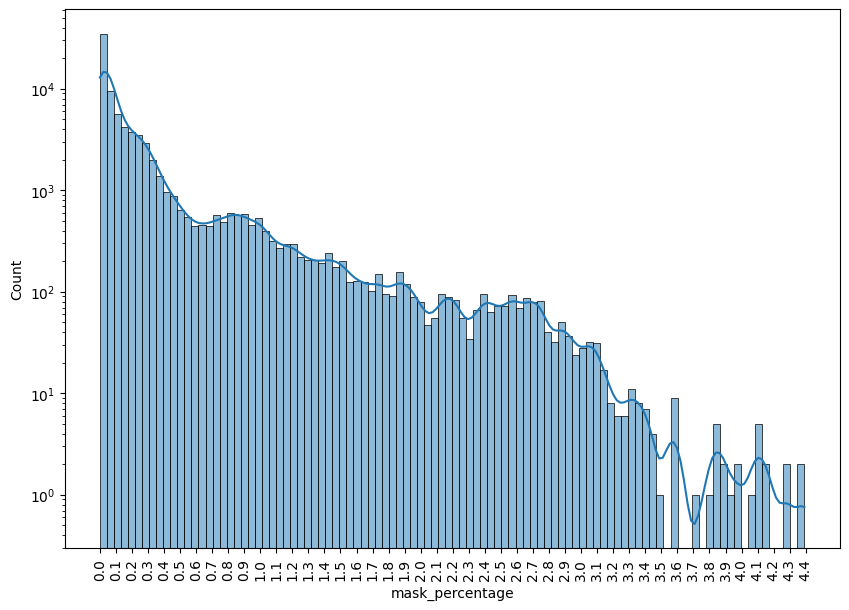

In [44]:
# Create a copy dataset with non-empty images only
df_nonempty = df[df['has_ship'] != 0]

plt.figure(figsize=(10, 7))
ax = sns.histplot(df_nonempty['mask_percentage'], bins=100, kde=True)
ax.set_yscale('log')
custom_ticks = np.arange(0, 4.5, 0.1)  # Ticks every 0.1 from 0 to 1.0
ax.set_xticks(custom_ticks)
ax.set_xticklabels([f'{tick:.1f}' for tick in custom_ticks], rotation=90)
plt.show()



Lets install exifread python package and try to fetch some metadata from the image

In [62]:
!pip install exifread


In [ ]:
import exifread

In [61]:
random_imgs = df.sample(500)
tags = []
for i in range(len(random_imgs)):
#     print(random_imgs['ImageId'].iloc[i])
    with open(os.path.join(TRAIN_IMG_DIR, random_imgs['ImageId'].iloc[i]), 'rb') as file:
        tags += [exifread.process_file(file)]

print(tags)

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},

Unfortunatelly, there is no any metadate in the training images. I was hoping to find some information about the spatial resolution or satelite information